Présenté par : **OUMELLAIK FATIMA-ZAHRA** & **Assaadi soukayna**

## **Handwritten Tifnagh Characters Recognition Using Deep Convolutional Neural Networks**






# Importer les bibliothéques

In [ ]:
import pathlib
import os
import cv2
import PIL
import numpy as np
import sys
import datetime
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
# graph
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# matrice de conf
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


# **Importation des données**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/archive.zip'
import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/dataTifinagh')

In [ ]:
data_dir = pathlib.Path('/content/dataTifinagh/AMHCD_64/AMHCD_64')
print("The data directory : {}".format(data_dir))

The data directory : /content/dataTifinagh/AMHCD_64/AMHCD_64


# Verification dataset

In [ ]:
image_count = len(list(data_dir.glob('*/*')))
print("Number of database images : {} ".format(image_count))

Number of database images : 25740 


(64, 64, 3)

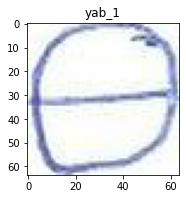

In [ ]:
import matplotlib.pyplot as plt
image = plt.imread("/content/dataTifinagh/amhcd_64/AMHCD_64/yab/yab_1.jpeg")
plt.subplot(121)
plt.imshow(image)
plt.title("yab_1")
image.shape

# **Diviser les données**

In [ ]:
batch_size = 32
img_height = 32
img_width = 32


Chargeons ces images hors disque à l'aide de l'utilitaire utile tf.keras.utils.image_dataset_from_directory .

Cela vous mènera d'un répertoire d'images sur disque à un tf.data.Dataset en seulement quelques lignes de code.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 25740 files belonging to 33 classes.
Using 20592 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 25740 files belonging to 33 classes.
Using 5148 files for validation.


Vous pouvez trouver les noms de classe dans l'attribut class_names sur ces ensembles de données. Ceux-ci correspondent aux noms des répertoires par ordre alphabétique

In [ ]:
class_names = train_ds.class_names
print(class_names)

['ya', 'yab', 'yach', 'yad', 'yadd', 'yae', 'yaf', 'yag', 'yagh', 'yagw', 'yah', 'yahh', 'yaj', 'yak', 'yakw', 'yal', 'yam', 'yan', 'yaq', 'yar', 'yarr', 'yas', 'yass', 'yat', 'yatt', 'yaw', 'yax', 'yay', 'yaz', 'yazz', 'yey', 'yi', 'yu']


# Visualisez les données

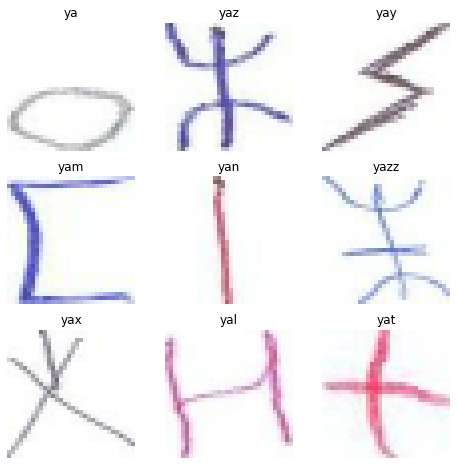

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 32, 32, 3)
(32,)


L' image_batch est un tenseur de la forme (32, 32, 32, 3) . Il s'agit d'un lot de 32 images de forme 32x32x3.

Le label_batch est un tenseur de la forme (32,) , ce sont des labels correspondants aux 32 images.

# **Création de model**

In [ ]:
from tensorflow import keras
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  #Add layer 1 .
  layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding="same"),  #(batch_size, height, width, depth)

  #Add layer 2.
  layers.Conv2D(filters=32, kernel_size=(3, 3),padding="same", activation='relu', name="Conv2"),
  layers.MaxPooling2D(pool_size=(2, 2), name="Pool1"),
  layers.Dropout(0.5, name="Drop1"),

  #Add layer 3.
  layers.Conv2D(filters=64, kernel_size=(3, 3),activation='relu', name="Conv3"),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1),padding='same',name="Pool2" ),
  layers.Dropout(0.5, name="Drop2"),
  layers.Flatten(),
  #Add layer 4.
  layers.Dense(64,activation='relu', name="Dense64"),
  layers.Dense(num_classes, activation='softmax', name="Dense33"),
])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Drop1 (Dropout)             (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 14, 14, 64)        18496     
                                                                 
 Pool2 (MaxPooling2D)        (None, 14, 14, 64)        0

# **Compilation**

Pour afficher la précision de la formation et de la validation pour chaque époque de formation, transmettez l'argument metrics à Model.compile .

In [ ]:
model.compile(optimizer='RMSProp',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# **L'entrainement**

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


644/644 [==============================] - 19s 15ms/step - loss: 1.1053 - accuracy: 0.7055 - val_loss: 0.1966 - val_accuracy: 0.9485
Epoch 2/10
644/644 [==============================] - 10s 15ms/step - loss: 0.1858 - accuracy: 0.9485 - val_loss: 0.1089 - val_accuracy: 0.9703
Epoch 3/10
644/644 [==============================] - 13s 20ms/step - loss: 0.1161 - accuracy: 0.9671 - val_loss: 0.0795 - val_accuracy: 0.9810
Epoch 4/10
644/644 [==============================] - 11s 17ms/step - loss: 0.0830 - accuracy: 0.9757 - val_loss: 0.0616 - val_accuracy: 0.9858
Epoch 5/10
644/644 [==============================] - 10s 16ms/step - loss: 0.0688 - accuracy: 0.9807 - val_loss: 0.0691 - val_accuracy: 0.9819
Epoch 6/10
644/644 [==============================] - 11s 17ms/step - loss: 0.0592 - accuracy: 0.9832 - val_loss: 0.0616 - val_accuracy: 0.9856
Epoch 7/10
644/644 [==============================] - 11s 17ms/step - loss: 0.0484 - accuracy: 0.9868 - val_loss: 0.0663 - val_accuracy: 0.9856
Epo

# Evaluation

In [ ]:
score = model.evaluate(val_ds, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

161/161 [==============================] - 2s 13ms/step - loss: 0.0688 - accuracy: 0.9862
Test loss: 0.06878238171339035
Test accuracy: 0.9862082600593567


# **Courbes**

In [ ]:
import matplotlib.pyplot as plt
def summarize_diagnostics(history):
	plt.figure(1)
	plt.subplot(211)
	plt.title('Cross Entropy Loss(courbe d\'erreur)')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='red', label='test')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	# plot accuracy
	plt.figure(2)
	plt.subplot(212)
	plt.title('Classification Accuracy(courbe de précision)')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='red', label='test')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()

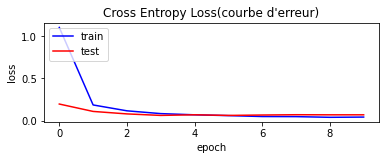

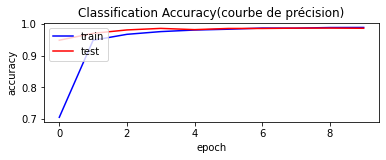

In [ ]:
summarize_diagnostics(history)

# **La prédiction et Matrice de confusion**

In [ ]:
import tensorflow_datasets as tfds
TRAIN_BUF=1000
BATCH_SIZE=30000
dataset_testRGB = keras.utils.image_dataset_from_directory(batch_size=BATCH_SIZE,
                                    directory=data_dir,
                                    shuffle=True,
                                    image_size=(32, 32),
                                    subset="validation",
                                    label_mode='categorical',
                                    validation_split=0.99,
                                    seed=18)
#on prend le premier epoch
dataset_testRGB=dataset_testRGB.take(1)
#chargement les images en tableau numpy pour la predicition
for image, label in tfds.as_numpy(dataset_testRGB):
  Img_testRGB = image
  labelsRGB=label
  labelsRGB=np.argmax(labelsRGB, axis=1)

Found 25740 files belonging to 33 classes.
Using 25482 files for validation.


In [ ]:
pred = model.predict(Img_testRGB)
#classes predites à partir des hot encoding
classesRGB=np.argmax(pred,axis=1)

797/797 [==============================] - 2s 2ms/step


In [ ]:
MC_RGB=np.array(tf.math.confusion_matrix(labelsRGB,classesRGB))
MC_RGB

array([[771,   0,   0, ...,   0,   0,   0],
       [  0, 766,   0, ...,   0,   0,   0],
       [  0,   1, 760, ...,   0,   0,   7],
       ...,
       [  0,   0,   0, ..., 767,   0,   6],
       [  0,   0,   0, ...,   0, 771,   0],
       [  0,   0,   0, ...,   0,   0, 771]], dtype=int32)

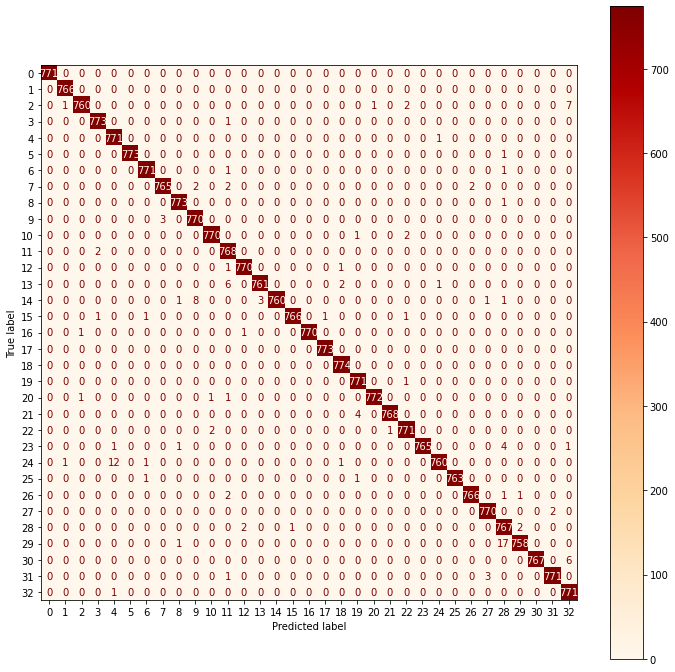

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp =ConfusionMatrixDisplay(confusion_matrix=MC_RGB)
fig, ax = plt.subplots(figsize=(12,12))
cmp.plot(ax=ax,cmap=plt.cm.OrRd)
plt.show()